In [5]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

### Gradient boost guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [6]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.

### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!

In [124]:
params = {'n_estimators': [100],
          'max_depth': [2 ,3, 4, 5],
          'subsample' : [1],
          'learning_rate' : [0.1, 0.2, 0.3, 0.4],
          'max_features' : [2],
          'min_samples_leaf' : [1],
          'loss': ['deviance', 'exponential']}


from sklearn.grid_search import GridSearchCV

grid = GridSearchCV(ensemble.GradientBoostingClassifier(), params, cv=10, scoring='accuracy')
grid.fit(X, y)

print('Best Paramters\n %s\n' % (grid.best_params_))

print('Best score found by search\n %s\n' % (grid.best_score_))

print('Best estimator found\n %s\n' % (grid.best_estimator_))

Best Paramters
 {'learning_rate': 0.4, 'loss': 'deviance', 'max_depth': 2, 'max_features': 2, 'min_samples_leaf': 1, 'n_estimators': 100, 'subsample': 1}

Best score found by search
 0.7526696943660243

Best estimator found
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.4, loss='deviance', max_depth=2,
              max_features=2, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1, verbose=0, warm_start=False)



In [125]:
#Set the parameters to the results from the grid search
params = grid.best_params_

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

traintype1tobeat = 0.04650845608292417
traintype2tobeat = 0.17607746863066012

testtype1tobeat = 0.06257668711656442
testtype2tobeat = 0.18527607361963191

print((
    '\nTraining set accuracy improvement:\n'
    'Percent Type I errors improvement: {}\n'
    'Percent Type II errors improvement: {}\n\n'
    'Test set accuracy improvement:\n'
    'Percent Type I errors improvement: {}\n'
    'Percent Type II errors improvement: {}'

.format(traintype1tobeat-train_tI_errors,
        traintype2tobeat-train_tII_errors,
        testtype1tobeat-test_tI_errors,
        testtype2tobeat-test_tII_errors)))

Training set accuracy:
Percent Type I errors: 0.04773595199127114
Percent Type II errors: 0.18562465902891434

Test set accuracy:
Percent Type I errors: 0.05766871165644172
Percent Type II errors: 0.18650306748466258

Training set accuracy improvement:
Percent Type I errors improvement: -0.0012274959083469691
Percent Type II errors improvement: -0.009547190398254218

Test set accuracy improvement:
Percent Type I errors improvement: 0.004907975460122699
Percent Type II errors improvement: -0.0012269938650306678


Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

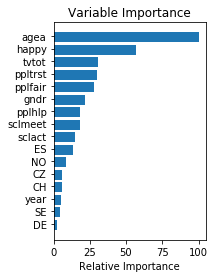

In [52]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos-.5, feature_importance[sorted_idx], align='edge')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.